# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [82]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=2.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [83]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.82842712e+00, -2.68584617e+00, -2.00000000e+00, -1.62721301e+00,
       -1.23606798e+00, -1.23606798e+00, -7.15114400e-16,  6.49377012e-17,
        1.40663819e-16,  5.24028182e-16,  1.60221139e-15,  7.63932023e-01,
        7.63932023e-01,  1.05863316e+00,  1.17157288e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.82842712e+00,  2.94136684e+00,  3.23606798e+00,
        3.23606798e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  5.23606798e+00,  5.23606798e+00,
        5.62721301e+00,  6.00000000e+00,  6.68584617e+00,  6.82842712e+00])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [84]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [85]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [86]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,2.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,2.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,2.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,2.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [87]:
print(blocks['0,0'])

SummedOp([
  4.0 * III,
  -0.5 * IIX,
  0.5 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.0 * IZI,
  -0.5 * IZX,
  0.5 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -1.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [88]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-88-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-88-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [89]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,4,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,2,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,2,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,2,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,2,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,2,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,2,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,4,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [90]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-2.8284271247461987
-2.828427124746189


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [91]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [92]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


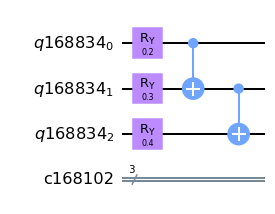

In [93]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [94]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


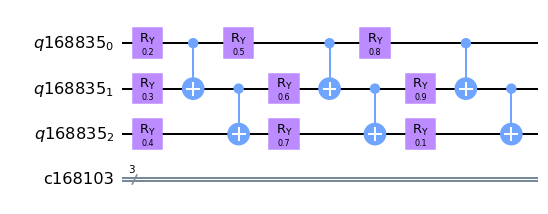

In [95]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [96]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

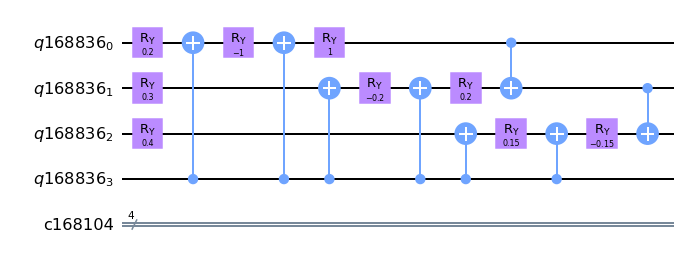

In [97]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [98]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [99]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

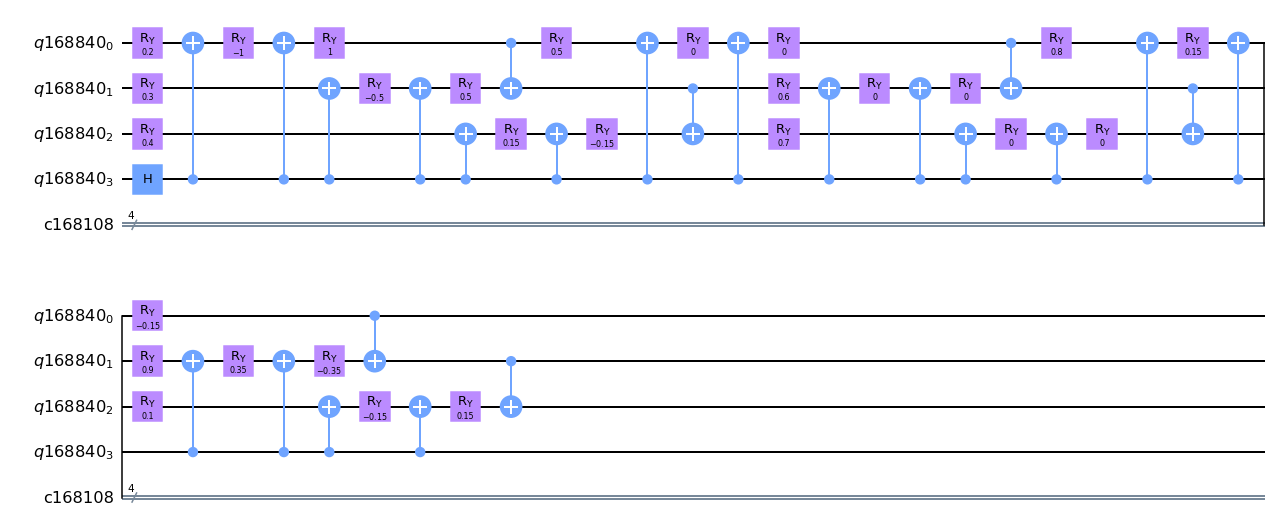

In [100]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [101]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.7209464513295367+0j)
0.7209464513295365
0.705078125


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [102]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (4.854753923078022+0j)
simple: (4.854753923078022+0j)
matrix: 4.854753923078022
simulator: 4.912109375


In [103]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.8163685946378345+0j)
simple: (-0.8163685946378343+0j)
matrix: -0.8163685946378342
simulator: -0.8076171875


Now we need to add all of the blocks together

In [104]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E
            
find_E(alpha,phi,blocks)

(2.4967499013152743+0j)

In [105]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(2.496749901315275+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [106]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(0.6666666666666669+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [107]:
import copy

In [108]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [109]:
out = SPSA(2000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= -0.8489988245187408 E_A= (1.7470692666476797+0j) E_B= (2.4262683262626723+0j) E_f= 0.6006270315481754
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= 1.3275030638161864 E_A= (1.7021437186245725+0j) E_B= (0.711946984700009+0j) E_f= 0.4754281296796993
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= -1.3021707916484841 E_A= (1.5094361920337922+0j) E_B= (2.4417641118298343+0j) E_f= 0.5304007898697763
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= -0.5347674522909214 E_A= (1.308830068199612+0j) E_B= (1.680747808649462+0j) E_f= 0.549769569882771
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 1.217243244749022 E_A= (2.4224835517517227+0j) E_B= (1.5947865355339135+0j) E_f= 0.5888305583646412
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= -0.5623938960739346 E_A= (1.8380095799495673+0j) E_B= (2.2134467858947677+0j) E_f= 0.6254185296849648
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= -3.

k= 51 c_k= 0.268375986369122 a_k= 0.021812190135384178 g= -0.27711499286245356 E_A= (0.4371680896012579+0j) E_B= (0.5859101086955243+0j) E_f= -0.15719601960334137
k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= -2.212803575580866 E_A= (0.7937835687957592+0j) E_B= (1.979227420913617+0j) E_f= -0.09462122687111815
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= 0.5237859322867674 E_A= (1.1521159595523118+0j) E_B= (0.8720424410837473+0j) E_f= -0.09322747805795774
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= -0.20667347597247795 E_A= (0.5456426713968721+0j) E_B= (0.6559484080063878+0j) E_f= -0.09709793514590642
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= 1.1464501616747962 E_A= (1.2447470804623046+0j) E_B= (0.6339764067362375+0j) E_f= -0.1363379977152886
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -0.210082554438002 E_A= (0.4730617070307039+0j) E_B= (0.584783170504859+0j) E_f= -0.13468965809339045
k= 57 c_k= 0.2654322961406756

k= 102 c_k= 0.25047444999544133 a_k= 0.019333088419998635 g= -0.26868181018014253 E_A= (0.40897260478843106+0j) E_B= (0.5435684620457326+0j) E_f= -0.6603711438268565
k= 103 c_k= 0.25023014297472496 a_k= 0.019298881045265278 g= 2.672926677861181 E_A= (1.3364607650423115+0j) E_B= (-0.0012328844820084228+0j) E_f= -0.6645867528376765
k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= -0.2786225147265752 E_A= (0.44701752748250295+0j) E_B= (0.5863223256730346+0j) E_f= -0.6670333130631827
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= -1.8804480536103299 E_A= (0.15220332073565962+0j) E_B= (1.0914841000338318+0j) E_f= -0.6677021193302328
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= -0.16298249078264088 E_A= (0.5395515034095194+0j) E_B= (0.6208838262886534+0j) E_f= -0.6685808297530391
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= 3.00536730424239 E_A= (1.293694038757146+0j) E_B= (-0.20465069249727233+0j) E_f= -0.7931269201942318
k= 108 c_k= 0.

k= 152 c_k= 0.24066124374307757 a_k= 0.017960577462650416 g= 2.1329201010361993 E_A= (0.866954817156468+0j) E_B= (-0.15966759148349685+0j) E_f= -1.0577300300175436
k= 153 c_k= 0.24050294487280224 a_k= 0.017938510984476064 g= 0.3992121336847561 E_A= (0.19113510892888558+0j) E_B= (-0.0008882786313917381+0j) E_f= -1.066266665856553
k= 154 c_k= 0.24034577371294386 a_k= 0.017916605514221893 g= -1.3095448581841709 E_A= (-0.11792914761157736+0j) E_B= (0.5115579966925864+0j) E_f= -1.040359006575092
k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= -0.5051739753954007 E_A= (0.038624279506280654+0j) E_B= (0.2812994658894033+0j) E_f= -1.0441006727084765
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= -0.3050665686658711 E_A= (-0.10528606663580939+0j) E_B= (0.04116709082879569+0j) E_f= -1.0395090985354745
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= 0.19730731344977645 E_A= (0.5876072673807664+0j) E_B= (0.4929467651252242+0j) E_f= -1.041602496693489
k= 158 c_

k= 202 c_k= 0.2338852810506788 a_k= 0.017020240953425587 g= 2.7405738548911898 E_A= (1.1327244537755599+0j) E_B= (-0.14923531880717625+0j) E_f= -1.1027681555313367
k= 203 c_k= 0.23376922896323718 a_k= 0.01700422472485619 g= 1.4838859886979634 E_A= (0.731776651675509+0j) E_B= (0.038002884780961504+0j) E_f= -1.0933628558558892
k= 204 c_k= 0.23365380153244633 a_k= 0.016988298130522942 g= -2.4757276490646207 E_A= (-0.1805170693842451+0j) E_B= (0.9764092841416246+0j) E_f= -1.1164662854374792
k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= 0.280633251022651 E_A= (0.35944082327800514+0j) E_B= (0.22836320993737572+0j) E_f= -1.1128465778163927
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 0.5281042125913945 E_A= (0.5441669367844948+0j) E_B= (0.29762170145060196+0j) E_f= -1.1221292101213634
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= -1.3341502218265568 E_A= (-0.1208993496967761+0j) E_B= (0.5016450389354605+0j) E_f= -1.1171120579971283
k= 208 c_k= 0.2

k= 252 c_k= 0.22874142308596035 a_k= 0.01631394143418331 g= 2.040858725453481 E_A= (0.6664291832707703+0j) E_B= (-0.26722867508448656+0j) E_f= -1.0501515803852144
k= 253 c_k= 0.22865030548461726 a_k= 0.016301501753668856 g= 1.886493053607621 E_A= (0.4198238759894426+0j) E_B= (-0.4428705500145393+0j) E_f= -1.0492148730062902
k= 254 c_k= 0.22855958199258958 a_k= 0.016289118535963962 g= 0.41628560008292076 E_A= (0.172100382077648+0j) E_B= (-0.018191743411325352+0j) E_f= -1.0540781807394826
k= 255 c_k= 0.22846924936970905 a_k= 0.01627679131316657 g= -0.023479954365893237 E_A= (-0.08945456250622945+0j) E_B= (-0.07872566740780815+0j) E_f= -1.05413863387412
k= 256 c_k= 0.22837930441497245 a_k= 0.01626451962299262 g= 0.8792850494479315 E_A= (0.26054124338283147+0j) E_B= (-0.14107977256797505+0j) E_f= -1.066655913060126
k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= 0.5533487346821201 E_A= (-0.13230502833460367+0j) E_B= (-0.38495271026349526+0j) E_f= -1.0600321723070725
k= 258 c_k

k= 302 c_k= 0.22461268833742742 a_k= 0.015753084133937546 g= 0.8708645431049202 E_A= (0.2352473553645468+0j) E_B= (-0.15596709704453632+0j) E_f= -1.0964700203354327
k= 303 c_k= 0.2245379531555281 a_k= 0.015742987298995027 g= 0.9176020624889858 E_A= (0.057502326132908954+0j) E_B= (-0.3545706517122268+0j) E_f= -1.1005571073976186
k= 304 c_k= 0.22446348815402628 a_k= 0.015732929009181187 g= 1.026022314541256 E_A= (0.18727201638179158+0j) E_B= (-0.273337078909804+0j) E_f= -1.13281483082937
k= 305 c_k= 0.22438929147512626 a_k= 0.01572290899568147 g= 3.6313892276776802 E_A= (0.5709780056304182+0j) E_B= (-1.058711706107583+0j) E_f= -1.214535746954281
k= 306 c_k= 0.2243153612798253 a_k= 0.015712926992399172 g= 0.6446227078889043 E_A= (-0.1701550243028041+0j) E_B= (-0.4593525755213618+0j) E_f= -1.2083070366250377
k= 307 c_k= 0.2242416957476633 a_k= 0.015702982735919514 g= 1.6520025177441715 E_A= (0.072859782830064+0j) E_B= (-0.6680359090866606+0j) E_f= -1.2049943852549259
k= 308 c_k= 0.22416829

k= 352 c_k= 0.22117434310863096 a_k= 0.015290749469948869 g= -0.6982878676692735 E_A= (-0.4077332027601449+0j) E_B= (-0.09884648189518855+0j) E_f= -1.203547841091343
k= 353 c_k= 0.2211111594237067 a_k= 0.015282296669408172 g= 0.6847372944892082 E_A= (0.07651861555391833+0j) E_B= (-0.22628749861640352+0j) E_f= -1.1918866096470835
k= 354 c_k= 0.2210481719458794 a_k= 0.015273871712561216 g= -1.0568266698681599 E_A= (-0.46575712439154504+0j) E_B= (0.001462082484471161+0j) E_f= -1.1787825355315222
k= 355 c_k= 0.22098537951573047 a_k= 0.015265474431782224 g= 0.8914852495667429 E_A= (0.1543837768570383+0j) E_B= (-0.23962663555932637+0j) E_f= -1.1664413689208177
k= 356 c_k= 0.22092278098392504 a_k= 0.015257104660909059 g= -0.000348034683826616 E_A= (-0.09787436843751912+0j) E_B= (-0.09772059085705945+0j) E_f= -1.1664449713485832
k= 357 c_k= 0.2208603752110963 a_k= 0.015248762235226495 g= 0.57736842933769 E_A= (-0.07947044224840791+0j) E_B= (-0.334506058125535+0j) E_f= -1.1501440885320846
k= 35

k= 402 c_k= 0.21823488881276693 a_k= 0.014899237531253662 g= -1.2965482320558277 E_A= (-0.44903736768789904+0j) E_B= (0.11686675083828708+0j) E_f= -1.2413129749384166
k= 403 c_k= 0.2181802692919501 a_k= 0.014891996853004833 g= -0.4192178016375393 E_A= (-0.6733849429258507+0j) E_B= (-0.4904548372193354+0j) E_f= -1.2448124923165582
k= 404 c_k= 0.2181257984204375 a_k= 0.014884777149313447 g= -1.1947264610639008 E_A= (-0.40265428343396803+0j) E_B= (0.11854704299320612+0j) E_f= -1.2503147038712101
k= 405 c_k= 0.2180714754281335 a_k= 0.014877578309099124 g= 1.6080317737388032 E_A= (0.24748269747477997+0j) E_B= (-0.45384902539429883+0j) E_f= -1.248208897996591
k= 406 c_k= 0.2180172995508166 a_k= 0.014870400222135 g= -1.0877817857960168 E_A= (-0.17097405295582097+0j) E_B= (0.3033364419238038+0j) E_f= -1.2349947188655723
k= 407 c_k= 0.21796327003008015 a_k= 0.014863242779039117 g= -0.05013745721176177 E_A= (-0.22318050345385068+0j) E_B= (-0.20132425520411304+0j) E_f= -1.2364144351140247
k= 408 

k= 452 c_k= 0.21567215256347394 a_k= 0.014560900196744206 g= 0.25684975525373266 E_A= (-0.3126298167006808+0j) E_B= (-0.42342049590262876+0j) E_f= -1.4061164790183525
k= 453 c_k= 0.2156241250645643 a_k= 0.014554587127563468 g= 1.3457272896952173 E_A= (0.20747389848624528+0j) E_B= (-0.372868640345832+0j) E_f= -1.3972451058866764
k= 454 c_k= 0.21557621389665993 a_k= 0.014548290377782385 g= -2.6875295513667514 E_A= (-0.7473797558925646+0j) E_B= (0.4113551349455021+0j) E_f= -1.3831309630863655
k= 455 c_k= 0.21552841852324142 a_k= 0.01454200987025535 g= -2.534312901462925 E_A= (-0.723256785070162+0j) E_B= (0.36917611832054115+0j) E_f= -1.4157516594945108
k= 456 c_k= 0.21548073841143345 a_k= 0.014535745528365998 g= 0.5247135287197695 E_A= (-0.3630435742137824+0j) E_B= (-0.5891748914597921+0j) E_f= -1.4234926467963762
k= 457 c_k= 0.2154331730319722 a_k= 0.014529497276022436 g= -1.3980576164760672 E_A= (-0.7125355371165043+0j) E_B= (-0.11015956031859389+0j) E_f= -1.4197282857773295
k= 458 c_k=

k= 502 c_k= 0.21340354269566467 a_k= 0.014263838532262487 g= -0.33558855130783355 E_A= (-0.5781881287119146+0j) E_B= (-0.4349565572375196+0j) E_f= -1.5701571656715139
k= 503 c_k= 0.21336073911424763 a_k= 0.014258256309475912 g= 1.421358058879833 E_A= (-0.29966615181685147+0j) E_B= (-0.9061901637940383+0j) E_f= -1.555212422340424
k= 504 c_k= 0.21331802893631016 a_k= 0.014252687114763117 g= -0.12187762157533276 E_A= (-0.626371932291514+0j) E_B= (-0.574374544279723+0j) E_f= -1.5565777190704713
k= 505 c_k= 0.21327541177367956 a_k= 0.0142471308925097 g= 2.114287859863913 E_A= (-0.09469034867561017+0j) E_B= (-0.9965415765167458+0j) E_f= -1.5802684357360675
k= 506 c_k= 0.21323288724055947 a_k= 0.014241587587445861 g= -2.9448945756227594 E_A= (-1.2332712384856386+0j) E_B= (0.022625507472567585+0j) E_f= -1.6028370766156095
k= 507 c_k= 0.2131904549535107 a_k= 0.01423605714464361 g= 1.8562323402762837 E_A= (-0.013202091978800887+0j) E_B= (-0.8046641262246423+0j) E_f= -1.6029063718045724
k= 508 c_

k= 552 c_k= 0.21137068413339888 a_k= 0.013999670591670748 g= -1.1782902017881454 E_A= (-1.2195925899657774+0j) E_B= (-0.7214805778464956+0j) E_f= -1.816015054320759
k= 553 c_k= 0.21133211774271785 a_k= 0.013994677809553886 g= 0.31111975969155 E_A= (-0.5486287285444742+0j) E_B= (-0.6801279239189156+0j) E_f= -1.8097885212371558
k= 554 c_k= 0.21129362792147077 a_k= 0.013989695647927233 g= 0.700648521105838 E_A= (-0.8748883393940408+0j) E_B= (-1.170973475238572+0j) E_f= -1.8218304466342998
k= 555 c_k= 0.21125521438008454 a_k= 0.013984724065461768 g= -0.48126648074516454 E_A= (-1.1422463215913574+0j) E_B= (-0.9389062144638203+0j) E_f= -1.8351101676737467
k= 556 c_k= 0.21121687683059942 a_k= 0.013979763021061959 g= 0.1430827168141188 E_A= (-0.5864308052834803+0j) E_B= (-0.6468737744313109+0j) E_f= -1.8332768749900412
k= 557 c_k= 0.21117861498665738 a_k= 0.013974812473864031 g= 0.620448981179777 E_A= (-0.977230263734871+0j) E_B= (-1.239281376765727+0j) E_f= -1.8303949585531183
k= 558 c_k= 0.2

k= 602 c_k= 0.20953083456751354 a_k= 0.013762281883391469 g= -0.8810196813555956 E_A= (-1.1661540112236546+0j) E_B= (-0.796952433013969+0j) E_f= -1.9671221387158395
k= 603 c_k= 0.2094957710242249 a_k= 0.013757773707067985 g= 0.8871425405650424 E_A= (-0.9453874295822738+0j) E_B= (-1.3170926506704004+0j) E_f= -1.9648772843775153
k= 604 c_k= 0.20946077133826135 a_k= 0.013753274340242483 g= -0.7102142376327553 E_A= (-1.175309738595787+0j) E_B= (-0.8777856945358425+0j) E_f= -1.9684664936163605
k= 605 c_k= 0.20942583528806527 a_k= 0.01374878375141773 g= 1.5233648559933182 E_A= (-0.6720421159679367+0j) E_B= (-1.3101060307977046+0j) E_f= -1.9690024528131342
k= 606 c_k= 0.20939096265321175 a_k= 0.013744301909260001 g= 0.13323222385133518 E_A= (-0.7287514702401153+0j) E_B= (-0.7845467174574339+0j) E_f= -1.9695962565862077
k= 607 c_k= 0.2093561532144009 a_k= 0.01373982878259797 g= 0.07000245656866848 E_A= (-0.7578385554244877+0j) E_B= (-0.787149445470037+0j) E_f= -1.9694125994389036
k= 608 c_k= 0

k= 652 c_k= 0.20785178572027052 a_k= 0.013547082796837265 g= -0.96255019616812 E_A= (-1.281605195893543+0j) E_B= (-0.8814696416556622+0j) E_f= -2.023652840946406
k= 653 c_k= 0.20781966420186904 a_k= 0.01354297947844509 g= 0.6805506408590217 E_A= (-1.0188263494823966+0j) E_B= (-1.301689960793774+0j) E_f= -2.0192741562739034
k= 654 c_k= 0.20778759671414168 a_k= 0.013538883575164739 g= 0.3958480256184109 E_A= (-1.0912073406030933+0j) E_B= (-1.2557119604176685+0j) E_f= -2.026052288072972
k= 655 c_k= 0.20775558308392328 a_k= 0.013534795062475995 g= 0.44389796578981605 E_A= (-0.7272504683395534+0j) E_B= (-0.9116950297644147+0j) E_f= -2.024850338936104
k= 656 c_k= 0.20772362313886658 a_k= 0.013530713915976387 g= 1.240562433086946 E_A= (-0.45746496204670517+0j) E_B= (-0.9728532087082815+0j) E_f= -2.013287881302243
k= 657 c_k= 0.20769171670743708 a_k= 0.013526640111380443 g= 0.9895131628947217 E_A= (-0.6270559439477688+0j) E_B= (-1.03808331896019+0j) E_f= -2.008873004897359
k= 658 c_k= 0.207659

k= 702 c_k= 0.2063086814842758 a_k= 0.013350545426441141 g= -1.8734192611255687 E_A= (-1.17286010448108+0j) E_B= (-0.39985478922095546+0j) E_f= -2.052413967455439
k= 703 c_k= 0.20627906430640094 a_k= 0.013346784974967 g= 0.49990526296055793 E_A= (-1.1144141375131684+0j) E_B= (-1.3206541172838668+0j) E_f= -2.051167378148877
k= 704 c_k= 0.20624949341125984 a_k= 0.013343030843532541 g= -1.8037363290923054 E_A= (-1.3637208275025627+0j) E_B= (-0.6196814192570158+0j) E_f= -2.038545884078001
k= 705 c_k= 0.2062199686610309 a_k= 0.013339283012698969 g= 0.9207175177787323 E_A= (-1.012467495014404+0j) E_B= (-1.3922081703383886+0j) E_f= -2.04057175016543
k= 706 c_k= 0.20619048991849742 a_k= 0.013335541463114317 g= -0.5411886237507921 E_A= (-1.2932716336006247+0j) E_B= (-1.0700957386616383+0j) E_f= -2.036789261074179
k= 707 c_k= 0.2061610570470442 a_k= 0.013331806175512943 g= -1.7696737621023964 E_A= (-1.3307982318822964+0j) E_B= (-0.6011226050353975+0j) E_f= -2.0289453970046916
k= 708 c_k= 0.20613

k= 752 c_k= 0.2048819498950429 a_k= 0.013169902876675684 g= 1.8306691278756462 E_A= (-0.7266286838957323+0j) E_B= (-1.4767708049593724+0j) E_f= -2.0076587282579403
k= 753 c_k= 0.20485448912108623 a_k= 0.013166436206811927 g= 1.1967851999994652 E_A= (-0.49059508765685883+0j) E_B= (-0.9809287291239938+0j) E_f= -2.0150702017596758
k= 754 c_k= 0.20482706841644296 a_k= 0.013162974982238293 g= -0.6198209643918081 E_A= (-1.1827008194771584+0j) E_B= (-0.9287885973183053+0j) E_f= -2.0220932597594574
k= 755 c_k= 0.20479968766969023 a_k= 0.013159519187300288 g= 0.3517312198912263 E_A= (-0.9185574692300132+0j) E_B= (-1.0626263571848178+0j) E_f= -2.0241509282643246
k= 756 c_k= 0.20477234676986175 a_k= 0.013156068806408787 g= 0.9430485950520031 E_A= (-0.9584151793850978+0j) E_B= (-1.3446357272387373+0j) E_f= -2.017552330038309
k= 757 c_k= 0.20474504560644552 a_k= 0.013152623824039672 g= 1.22307606094393 E_A= (-0.9032102676370399+0j) E_B= (-1.4040477953932733+0j) E_f= -2.0170877411849633
k= 758 c_k= 

k= 802 c_k= 0.20355591240941873 a_k= 0.01300294736838163 g= -1.3127841748234699 E_A= (-1.6277720295146954+0j) E_B= (-1.0933220685090208+0j) E_f= -2.037524430118253
k= 803 c_k= 0.20353032702333557 a_k= 0.012999734989902487 g= 0.2197741591924767 E_A= (-1.2340035580575506+0j) E_B= (-1.3234649710409974+0j) E_f= -2.0400485333008684
k= 804 c_k= 0.20350477664999173 a_k= 0.012996527347569967 g= 0.11870815516292868 E_A= (-0.9787116686467922+0j) E_B= (-1.0270270218527209+0j) E_f= -2.0371794581118965
k= 805 c_k= 0.20347926119806856 a_k= 0.012993324428602978 g= -0.29783943696277093 E_A= (-1.4931182918725077+0j) E_B= (-1.371909994694841+0j) E_f= -2.0353459207037923
k= 806 c_k= 0.2034537805765985 a_k= 0.012990126220270537 g= -1.1725622923916295 E_A= (-1.2511041748419425+0j) E_B= (-0.7739797121446627+0j) E_f= -2.0509283402195573
k= 807 c_k= 0.2034283346949633 a_k= 0.012986932709891496 g= -1.6989169875019883 E_A= (-1.4201907751221723+0j) E_B= (-0.7289750680171458+0j) E_f= -2.0553805730314134
k= 808 c_

k= 852 c_k= 0.20231782111629845 a_k= 0.012847890732284243 g= 1.349902193675794 E_A= (-0.8984879197243282+0j) E_B= (-1.4447064608135245+0j) E_f= -2.0663419014808446
k= 853 c_k= 0.20229388099530227 a_k= 0.01284490043027062 g= -0.5719101104247689 E_A= (-1.1947273829112748+0j) E_B= (-0.963339551274718+0j) E_f= -2.0689321140788786
k= 854 c_k= 0.2022699717186844 a_k= 0.012841914282029087 g= 0.09109474926636334 E_A= (-1.0381376254309371+0j) E_B= (-1.074989090146593+0j) E_f= -2.067111147823507
k= 855 c_k= 0.2022460932106994 a_k= 0.01283893227699766 g= -0.650908565632067 E_A= (-1.2511449402796804+0j) E_B= (-0.987857511406749+0j) E_f= -2.0596087854897998
k= 856 c_k= 0.202222245395876 a_k= 0.012835954404653373 g= -1.6128922160864203 E_A= (-1.65864906179108+0j) E_B= (-1.0063236907540274+0j) E_f= -2.0569852939065147
k= 857 c_k= 0.2021984281990159 a_k= 0.012832980654512086 g= 0.7834325717830074 E_A= (-1.2835647515658402+0j) E_B= (-1.6003824207947137+0j) E_f= -2.0568125140147107
k= 858 c_k= 0.2021746

k= 902 c_k= 0.20115717531282734 a_k= 0.01270326558931641 g= 0.763859930417143 E_A= (-0.8009881694582579+0j) E_B= (-1.1082999813329886+0j) E_f= -2.077952930271378
k= 903 c_k= 0.20113468971101608 a_k= 0.012700470760911535 g= -1.590619295201654 E_A= (-1.5342982278925643+0j) E_B= (-0.8944407911150848+0j) E_f= -2.097025492117493
k= 904 c_k= 0.20111223147821555 a_k= 0.012697679602512855 g= 1.2275745069291297 E_A= (-1.1888580973851293+0j) E_B= (-1.6826185941737042+0j) E_f= -2.0937289526132785
k= 905 c_k= 0.20108980055092596 a_k= 0.012694892105298092 g= -1.942803173883342 E_A= (-1.6023550822493842+0j) E_B= (-0.8209992767575698+0j) E_f= -2.1061729521196493
k= 906 c_k= 0.20106739686586467 a_k= 0.012692108260475772 g= 0.6122926590917016 E_A= (-1.2121608937454436+0j) E_B= (-1.458385075912737+0j) E_f= -2.1071114803930264
k= 907 c_k= 0.20104502035996524 a_k= 0.01268932805928509 g= -1.0549269418383649 E_A= (-1.5364673666073785+0j) E_B= (-1.1122917496070386+0j) E_f= -2.0972047881370175
k= 908 c_k= 0.2

k= 952 c_k= 0.20006522569183946 a_k= 0.012567853818714506 g= -0.7140636843233691 E_A= (-1.7409759416237152+0j) E_B= (-1.4552573172987127+0j) E_f= -2.1550340578645955
k= 953 c_k= 0.20004403479568034 a_k= 0.01256523225631895 g= 0.1604607311277661 E_A= (-1.1427077376579682+0j) E_B= (-1.2069061618200945+0j) E_f= -2.156325126779562
k= 954 c_k= 0.20002286834158126 a_k= 0.012562613957965794 g= -1.1209370864896582 E_A= (-1.6222321558273087+0j) E_B= (-1.1738060532870755+0j) E_f= -2.16721425680124
k= 955 c_k= 0.2000017262758008 a_k= 0.012559998916214945 g= -0.8588468956108417 E_A= (-1.324809121352522+0j) E_B= (-0.9812673978949603+0j) E_f= -2.169184176934462
k= 956 c_k= 0.1999806085447715 a_k= 0.01255738712365095 g= -0.07925681069073733 E_A= (-1.3678937306538335+0j) E_B= (-1.3361940801873307+0j) E_f= -2.1704810393631138
k= 957 c_k= 0.19995951509509954 a_k= 0.012554778572882883 g= 0.9981543339606612 E_A= (-1.007642384211677+0j) E_B= (-1.4068232974293688+0j) E_f= -2.1703064545617674
k= 958 c_k= 0.1

k= 1002 c_k= 0.1990346076759931 a_k= 0.012440633781437406 g= 0.7412340621828102 E_A= (-1.2640574282950658+0j) E_B= (-1.5591198898203424+0j) E_f= -2.2699983090747273
k= 1003 c_k= 0.19901457630037048 a_k= 0.012438166766489485 g= 0.2897750651169323 E_A= (-1.4622354491046792+0j) E_B= (-1.5775743727179963+0j) E_f= -2.2659341833602014
k= 1004 c_k= 0.19899456687939127 a_k= 0.012435702671789855 g= -0.41190092249931 E_A= (-1.3780820750728588+0j) E_B= (-1.214149983732915+0j) E_f= -2.2669447251249117
k= 1005 c_k= 0.19897457936718335 a_k= 0.012433241491009774 g= 0.23334785854159934 E_A= (-1.542990215510283+0j) E_B= (-1.6358507995093785+0j) E_f= -2.2666031172156087
k= 1006 c_k= 0.19895461371801593 a_k= 0.012430783217840441 g= -1.8324134926309232 E_A= (-1.5017452242018243+0j) E_B= (-0.7726109870056928+0j) E_f= -2.2723762522435993
k= 1007 c_k= 0.19893466988629901 a_k= 0.012428327845992886 g= 1.874282437696104 E_A= (-0.9719043824792581+0j) E_B= (-1.7176238985127827+0j) E_f= -2.2805666839703487
k= 1008

k= 1052 c_k= 0.1980590656124216 a_k= 0.012320740716387005 g= -0.87592948601602 E_A= (-1.511399694524352+0j) E_B= (-1.1644281434389487+0j) E_f= -2.3148047424826306
k= 1053 c_k= 0.198040078419009 a_k= 0.012318412333635148 g= 0.9702033607890826 E_A= (-1.283723974597044+0j) E_B= (-1.668002273903156+0j) E_f= -2.330335735174829
k= 1054 c_k= 0.19802111104911638 a_k= 0.012316086577585084 g= 2.2448052708526802 E_A= (-0.7509520852069594+0j) E_B= (-1.63998975285328+0j) E_f= -2.3425976149495105
k= 1055 c_k= 0.1980021634632864 a_k= 0.01231376344281136 g= 0.761683605741356 E_A= (-1.0199377534224772+0j) E_B= (-1.3215677570450879+0j) E_f= -2.3350618266977907
k= 1056 c_k= 0.19798323562217748 a_k= 0.012311442923904797 g= -0.032452328463128635 E_A= (-1.6156150067471555+0j) E_B= (-1.6027649727619477+0j) E_f= -2.3346468199800308
k= 1057 c_k= 0.19796432748656353 a_k= 0.01230912501547244 g= 2.0269838010607253 E_A= (-1.145189026765883+0j) E_B= (-1.9477299967721726+0j) E_f= -2.3507255200064603
k= 1058 c_k= 0.1

k= 1102 c_k= 0.19713324214205905 a_k= 0.012207436568384427 g= -1.3133990988496977 E_A= (-1.7567134728020142+0j) E_B= (-1.238884227636615+0j) E_f= -2.358159309441651
k= 1103 c_k= 0.19711519996020607 a_k= 0.012205233179549309 g= -0.266293878733641 E_A= (-1.5976595565062472+0j) E_B= (-1.4926784141967262+0j) E_f= -2.3602741213407157
k= 1104 c_k= 0.19709717576254196 a_k= 0.012203032164901446 g= 1.1292484552728834 E_A= (-1.5815869894037353+0j) E_B= (-2.0267303519407323+0j) E_f= -2.358074486424043
k= 1105 c_k= 0.19707916951488932 a_k= 0.012200833519756737 g= -0.8172260830474675 E_A= (-1.9231864741291718+0j) E_B= (-1.60106999862337+0j) E_f= -2.3557543819751015
k= 1106 c_k= 0.1970611811831666 a_k= 0.01219863723944451 g= 0.43768718908295284 E_A= (-1.5428522729359593+0j) E_B= (-1.7153545818748126+0j) E_f= -2.3529257267637846
k= 1107 c_k= 0.19704321073338768 a_k= 0.012196443319307462 g= -0.05511959853398531 E_A= (-1.7554099184406702+0j) E_B= (-1.7336880331017266+0j) E_f= -2.352391017860377
k= 1108

k= 1152 c_k= 0.1962525151361561 a_k= 0.012100086686757827 g= 0.18446033149512084 E_A= (-1.3885057206758522+0j) E_B= (-1.4609073286733854+0j) E_f= -2.352458227773299
k= 1153 c_k= 0.19623533209539845 a_k= 0.012097996521303538 g= 0.11071871922524978 E_A= (-1.7499573298496123+0j) E_B= (-1.7934111791223004+0j) E_f= -2.352170631534843
k= 1154 c_k= 0.1962181654406977 a_k= 0.0120959085113429 g= -0.9478033745389994 E_A= (-2.0358110298384617+0j) E_B= (-1.6638585511373718+0j) E_f= -2.353128312258559
k= 1155 c_k= 0.19620101514226096 a_k= 0.012093822652805694 g= -0.5974992587393332 E_A= (-1.8126480487603482+0j) E_B= (-1.578188126537537+0j) E_f= -2.352446405138402
k= 1156 c_k= 0.19618388117037525 a_k= 0.012091738941632884 g= 0.3039728626799453 E_A= (-1.4611427141642865+0j) E_B= (-1.5804118661063289+0j) E_f= -2.3527148069623864
k= 1157 c_k= 0.19616676349540726 a_k= 0.012089657373776546 g= -0.1186542039105306 E_A= (-1.5095571008626214+0j) E_B= (-1.4630050785501156+0j) E_f= -2.352348099165537
k= 1158 c

k= 1202 c_k= 0.1954128698949315 a_k= 0.011998141607224547 g= 0.9606666256936257 E_A= (-1.5697572273885894+0j) E_B= (-1.945210472066732+0j) E_f= -2.3831064325522147
k= 1203 c_k= 0.1953964711638577 a_k= 0.011996154440447668 g= 0.2514229868618292 E_A= (-1.7261724104145628+0j) E_B= (-1.8244267392191196+0j) E_f= -2.384522141094456
k= 1204 c_k= 0.19538008742178167 a_k= 0.011994169238586446 g= 1.6909906241592414 E_A= (-1.4368168638169783+0j) E_B= (-2.09758865577227+0j) E_f= -2.3991164411523593
k= 1205 c_k= 0.19536371864258115 a_k= 0.011992185998083146 g= -2.171011214188698 E_A= (-1.9114877127463832+0j) E_B= (-1.0632140647090846+0j) E_f= -2.406752891438426
k= 1206 c_k= 0.1953473648002008 a_k= 0.0119902047153894 g= 0.9920478996505296 E_A= (-1.4105085651210558+0j) E_B= (-1.7980964510256658+0j) E_f= -2.4074596158300103
k= 1207 c_k= 0.19533102586865225 a_k= 0.011988225386966162 g= 0.8549425432065684 E_A= (-1.3358231470430488+0j) E_B= (-1.669816755089636+0j) E_f= -2.4095518325603846
k= 1208 c_k= 0.

k= 1252 c_k= 0.1946107978579541 a_k= 0.011901122647998813 g= 0.9694128548813798 E_A= (-1.3490927785329603+0j) E_B= (-1.7264091968174051+0j) E_f= -2.4161682056134453
k= 1253 c_k= 0.19459511784217856 a_k= 0.011899229545097966 g= 0.003167975294260509 E_A= (-1.624699914978717+0j) E_B= (-1.6259328600301324+0j) E_f= -2.416137102884111
k= 1254 c_k= 0.19457945158726725 a_k= 0.011897338240090437 g= 1.1864931466711188 E_A= (-1.356718188625172+0j) E_B= (-1.8184525602078068+0j) E_f= -2.412684891223219
k= 1255 c_k= 0.19456379907019314 a_k= 0.011895448729849526 g= 1.1035915108484227 E_A= (-1.3188354052703697+0j) E_B= (-1.7482733192149364+0j) E_f= -2.4171850036397773
k= 1256 c_k= 0.19454816026798608 a_k= 0.011893561011256418 g= 0.7251692416489743 E_A= (-1.330378411338527+0j) E_B= (-1.6125390950300043+0j) E_f= -2.419241958011198
k= 1257 c_k= 0.1945325351577325 a_k= 0.011891675081200185 g= -0.37156790944838697 E_A= (-1.7525208692403342+0j) E_B= (-1.6079567744238272+0j) E_f= -2.42082798331779
k= 1258 c_

k= 1302 c_k= 0.19384321550470007 a_k= 0.011808610404774296 g= -0.7979346497570503 E_A= (-2.0288818992104383+0j) E_B= (-1.7195334626673917+0j) E_f= -2.447234176816924
k= 1303 c_k= 0.19382819639672044 a_k= 0.01180680351538794 g= -0.1349458043240423 E_A= (-1.7368806298178803+0j) E_B= (-1.6845680260910125+0j) E_f= -2.4469991814065932
k= 1304 c_k= 0.1938131899644015 a_k= 0.011804998276749726 g= 1.5475060082955063 E_A= (-1.3377758765544128+0j) E_B= (-1.937630028468072+0j) E_f= -2.452932675481114
k= 1305 c_k= 0.19379819618734445 a_k= 0.011803194686097956 g= -1.5509951362727734 E_A= (-1.8416480579984842+0j) E_B= (-1.2404879385884682+0j) E_f= -2.450818309456813
k= 1306 c_k= 0.19378321504519896 a_k= 0.011801392740677642 g= -0.5617485340447863 E_A= (-1.7777581112954215+0j) E_B= (-1.5600432373471693+0j) E_f= -2.4511352258833874
k= 1307 c_k= 0.19376824651766306 a_k= 0.011799592437740486 g= -0.3784082807489993 E_A= (-1.8473612280533447+0j) E_B= (-1.7007142099963504+0j) E_f= -2.4478049263906367
k= 13

k= 1352 c_k= 0.19310739881232042 a_k= 0.011720235474842515 g= 0.780351707268655 E_A= (-1.5581691209055393+0j) E_B= (-1.8595524976043458+0j) E_f= -2.441094834724054
k= 1353 c_k= 0.19309298941410571 a_k= 0.011718507866623123 g= -1.2538432667566743 E_A= (-2.019673796116913+0j) E_B= (-1.5354571068473244+0j) E_f= -2.440383766994066
k= 1354 c_k= 0.19307859172807806 a_k= 0.011716781778890965 g= 0.9063804071975428 E_A= (-1.6144058623256783+0j) E_B= (-1.9644111675089253+0j) E_f= -2.4420353891796904
k= 1355 c_k= 0.1930642057360845 a_k= 0.011715057209195396 g= 1.0766599585975956 E_A= (-1.4255749402302367+0j) E_B= (-1.8413039397392175+0j) E_f= -2.444199174272941
k= 1356 c_k= 0.1930498314200134 a_k= 0.011713334155091525 g= 0.8263733032188969 E_A= (-1.389335436315983+0j) E_B= (-1.7083978900687984+0j) E_f= -2.4444459722795893
k= 1357 c_k= 0.1930354687617947 a_k= 0.011711612614140169 g= 1.2581396094682349 E_A= (-1.3251864764328831+0j) E_B= (-1.8109176149958472+0j) E_f= -2.450095346329091
k= 1358 c_k= 

k= 1402 c_k= 0.19240092983027848 a_k= 0.01163567091385414 g= -0.3502211545742276 E_A= (-1.7196027451020777+0j) E_B= (-1.5848369935294475+0j) E_f= -2.4926274502041665
k= 1403 c_k= 0.19238708458942214 a_k= 0.011634016436547939 g= 0.04260379740084661 E_A= (-1.468751460791437+0j) E_B= (-1.4851443015402115+0j) E_f= -2.492678293761614
k= 1404 c_k= 0.19237325020158347 a_k= 0.011632363363897958 g= 0.45419639418119473 E_A= (-1.6537705116503025+0j) E_B= (-1.8285209848072546+0j) E_f= -2.492727042389612
k= 1405 c_k= 0.19235942665053954 a_k= 0.011630711693720213 g= 1.3119581199840094 E_A= (-1.6640503929734094+0j) E_B= (-2.168785416472697+0j) E_f= -2.4975672457780624
k= 1406 c_k= 0.1923456139201031 a_k= 0.011629061423835654 g= -0.18246184043657196 E_A= (-1.950083020816478+0j) E_B= (-1.8798915513849495+0j) E_f= -2.4978954008728915
k= 1407 c_k= 0.1923318119941226 a_k= 0.011627412552070152 g= 0.4063081022975266 E_A= (-1.746932834041461+0j) E_B= (-1.9032247811270142+0j) E_f= -2.4975343521752
k= 1408 c_k

k= 1452 c_k= 0.19172165278612424 a_k= 0.011554626052704069 g= 0.9351357955250685 E_A= (-1.546405777662172+0j) E_B= (-1.9049773382572386+0j) E_f= -2.511413683498893
k= 1453 c_k= 0.19170833100082174 a_k= 0.01155303922629666 g= -1.189882408025546 E_A= (-1.9672786005452885+0j) E_B= (-1.511057859485656+0j) E_f= -2.5120715108642027
k= 1454 c_k= 0.19169501929924382 a_k= 0.011551453701116885 g= 0.16587614461085787 E_A= (-1.6697558087314457+0j) E_B= (-1.7333510702163708+0j) E_f= -2.512492475979625
k= 1455 c_k= 0.1916817176668353 a_k= 0.011549869475210596 g= -0.1979608617064623 E_A= (-1.6323248258422305+0j) E_B= (-1.5564338698368274+0j) E_f= -2.5126344512962207
k= 1456 c_k= 0.19166842608907192 a_k= 0.01154828654662791 g= 1.027948571048744 E_A= (-1.4857002913952346+0j) E_B= (-1.8797508608220812+0j) E_f= -2.5125549239499994
k= 1457 c_k= 0.19165514455146027 a_k= 0.011546704913423194 g= -0.8255505726301282 E_A= (-1.777099745832301+0j) E_B= (-1.460657717168365+0j) E_f= -2.5067626355113797
k= 1458 c_k

k= 1502 c_k= 0.19106763775725658 a_k= 0.011476841391918811 g= 0.5878627746804265 E_A= (-1.4301398847535216+0j) E_B= (-1.6547829881207525+0j) E_f= -2.4923009746570015
k= 1503 c_k= 0.19105480291591428 a_k= 0.0114753173139337 g= -0.4333834735551434 E_A= (-1.5338431606699783+0j) E_B= (-1.3682431724157937+0j) E_f= -2.4923819096616957
k= 1504 c_k= 0.19104197746685314 a_k= 0.011473794444463826 g= 0.2344061292247787 E_A= (-1.63876702537792+0j) E_B= (-1.728329846292825+0j) E_f= -2.4952764407512937
k= 1505 c_k= 0.1910291613969662 a_k= 0.011472272781754141 g= 1.79736153896876 E_A= (-1.3181100992279655+0j) E_B= (-2.004807034260691+0j) E_f= -2.499500219306205
k= 1506 c_k= 0.1910163546931735 a_k= 0.011470752324053311 g= 0.15042934819416043 E_A= (-1.5721838443475469+0j) E_B= (-1.6296527758093842+0j) E_f= -2.4997937631493765
k= 1507 c_k= 0.1910035573424219 a_k= 0.011469233069613692 g= 0.4194904313586996 E_A= (-1.6481114780422952+0j) E_B= (-1.8083598073635325+0j) E_f= -2.500297622647085
k= 1508 c_k= 0.

k= 1552 c_k= 0.1904371503997359 a_k= 0.011402084356914907 g= -1.008437475448741 E_A= (-1.8798986170495213+0j) E_B= (-1.4958106986879975+0j) E_f= -2.5120280139930946
k= 1553 c_k= 0.1904247696288194 a_k= 0.011400618625079502 g= 0.6236944475230904 E_A= (-1.7645987188137826+0j) E_B= (-2.002132461790499+0j) E_f= -2.5125980628482747
k= 1554 c_k= 0.1904123976265017 a_k= 0.011399154018351777 g= 1.0227747543001258 E_A= (-1.4048910129390177+0j) E_B= (-1.794388999335304+0j) E_f= -2.5144240009465633
k= 1555 c_k= 0.1904000343809395 a_k= 0.011397690535149997 g= -0.008276091737183572 E_A= (-1.8448787628598335+0j) E_B= (-1.8417272265572344+0j) E_f= -2.5144037788685085
k= 1556 c_k= 0.19038767988031316 a_k= 0.011396228173895668 g= 0.785411289111001 E_A= (-1.9061998520645538+0j) E_B= (-2.2052651182358525+0j) E_f= -2.5137476142447865
k= 1557 c_k= 0.19037533411282653 a_k= 0.011394766933013506 g= -0.5249562666308929 E_A= (-1.89109995196978+0j) E_B= (-1.6912225026608234+0j) E_f= -2.512127519804924
k= 1558 c_

k= 1602 c_k= 0.1898286265644105 a_k= 0.011330145746489193 g= -0.7893547876690713 E_A= (-2.1081348894878014+0j) E_B= (-1.808450619057278+0j) E_f= -2.496314515586173
k= 1603 c_k= 0.18981667016397408 a_k= 0.011328734393824768 g= 0.7251037963466817 E_A= (-1.8461986464708946+0j) E_B= (-2.1214722227624616+0j) E_f= -2.495796852904017
k= 1604 c_k= 0.18980472196770304 a_k= 0.011327324090977088 g= 1.0460317220297464 E_A= (-1.3727479218944039+0j) E_B= (-1.7698314422329111+0j) E_f= -2.4959830075787766
k= 1605 c_k= 0.18979278196486155 a_k= 0.01132591483651595 g= -1.0582256514401658 E_A= (-2.051923679072089+0j) E_B= (-1.6502364984052753+0j) E_f= -2.4987210686957795
k= 1606 c_k= 0.18978085014473448 a_k= 0.011324506629013973 g= -0.006335935023202437 E_A= (-1.7699366086335404+0j) E_B= (-1.76753173036321+0j) E_f= -2.4987829205570646
k= 1607 c_k= 0.18976892649662733 a_k= 0.011323099467046602 g= 0.6860828220105436 E_A= (-1.6723907373900329+0j) E_B= (-1.9327851386314678+0j) E_f= -2.49627309610385
k= 1608 c

k= 1652 c_k= 0.189240650885497 a_k= 0.011260836743658905 g= 1.0215507854065105 E_A= (-1.4789430197569855+0j) E_B= (-1.8655808908428229+0j) E_f= -2.493569962440663
k= 1653 c_k= 0.18922909193624446 a_k= 0.011259476183686196 g= 1.0171717213853144 E_A= (-1.642599404416607+0j) E_B= (-2.0275563667785463+0j) E_f= -2.4966924723881747
k= 1654 c_k= 0.18921754067875096 a_k= 0.01125811660534999 g= 0.02870141678718885 E_A= (-1.9745893245287678+0j) E_B= (-1.9854509475257032+0j) E_f= -2.496874104137427
k= 1655 c_k= 0.18920599710325528 a_k= 0.011256758007353106 g= 1.0448304895979206 E_A= (-1.7524775626631346+0j) E_B= (-2.1478539518396484+0j) E_f= -2.496897743137087
k= 1656 c_k= 0.1891944612000143 a_k= 0.01125540038840086 g= 0.8810676353376145 E_A= (-1.46662903055833+0j) E_B= (-1.8000152636552713+0j) E_f= -2.497085337543613
k= 1657 c_k= 0.18918293295930314 a_k= 0.011254043747201048 g= 0.1599610223674474 E_A= (-1.5880800456394712+0j) E_B= (-1.648603836380756+0j) E_f= -2.4957328192459154
k= 1658 c_k= 0.1

k= 1702 c_k= 0.18867193862015733 a_k= 0.0111939863858188 g= 0.4038303493420368 E_A= (-1.3349087787646767+0j) E_B= (-1.4872916885327117+0j) E_f= -2.498228763575336
k= 1703 c_k= 0.18866075264924406 a_k= 0.011192673366054378 g= -0.8938092886357251 E_A= (-1.8696512059176653+0j) E_B= (-1.5323977396798627+0j) E_f= -2.5014088036252478
k= 1704 c_k= 0.18864957390355216 a_k= 0.01119136126600088 g= 0.32325896741792864 E_A= (-1.8443462947998357+0j) E_B= (-1.9663116277276247+0j) E_f= -2.502524800333053
k= 1705 c_k= 0.1886384023741811 a_k= 0.011190050084478383 g= -0.41157369222245066 E_A= (-1.751054490466085+0j) E_B= (-1.595777282945913+0j) E_f= -2.5016588897152228
k= 1706 c_k= 0.18862723805224665 a_k= 0.01118873982030916 g= 1.0628976177354403 E_A= (-1.6787430651030435+0j) E_B= (-2.079725949034541+0j) E_f= -2.4978532672066462
k= 1707 c_k= 0.18861608092888063 a_k= 0.011187430472317676 g= 0.6355750939881191 E_A= (-1.5443610869513473+0j) E_B= (-1.7841204536794353+0j) E_f= -2.5000362379909946
k= 1708 c_

k= 1752 c_k= 0.18812132016571967 a_k= 0.011129439412476263 g= 0.9651150699040213 E_A= (-1.4671075535428482+0j) E_B= (-1.8302249956671988+0j) E_f= -2.50891148604005
k= 1753 c_k= 0.1881104848610926 a_k= 0.011128170974766347 g= -0.2796754723948455 E_A= (-2.028826873130393+0j) E_B= (-1.9236070956984939+0j) E_f= -2.5077972152828556
k= 1754 c_k= 0.18809965635574036 a_k= 0.01112690340036445 g= 0.08843882522564848 E_A= (-1.7383924705928346+0j) E_B= (-1.7716630958597344+0j) E_f= -2.5073324304863447
k= 1755 c_k= 0.18808883464152568 a_k= 0.01112563668819437 g= 1.872256082631492 E_A= (-1.3951023658891317+0j) E_B= (-2.0994032953544624+0j) E_f= -2.5161281701421516
k= 1756 c_k= 0.1880780197103258 a_k= 0.011124370837181857 g= 0.16930028901446922 E_A= (-1.8097873511417928+0j) E_B= (-1.8734706773302472+0j) E_f= -2.515537746371108
k= 1757 c_k= 0.18806721155403214 a_k= 0.011123105846254606 g= 0.7827756184511697 E_A= (-1.691185148867935+0j) E_B= (-1.985614004537124+0j) E_f= -2.5126333968002066
k= 1758 c_k=

k= 1802 c_k= 0.18758772779558183 a_k= 0.011067054425246838 g= 1.3580207835277052 E_A= (-1.4109635921740176+0j) E_B= (-1.9204596583362934+0j) E_f= -2.507824095250428
k= 1803 c_k= 0.18757722276065888 a_k= 0.011065827871772927 g= -0.6765688658307023 E_A= (-1.9546432238243385+0j) E_B= (-1.7008254061066346+0j) E_f= -2.5052846131447084
k= 1804 c_k= 0.18756672413511266 a_k= 0.011064602130097972 g= 0.18694217442405936 E_A= (-1.8296441028267778+0j) E_B= (-1.8997723653456091+0j) E_f= -2.5042087093862517
k= 1805 c_k= 0.18755623191148502 a_k= 0.01106337719923785 g= -1.305967347655783 E_A= (-1.721333448928495+0j) E_B= (-1.231448819476985+0j) E_f= -2.5091110077648966
k= 1806 c_k= 0.1875457460823306 a_k= 0.011062153078210174 g= -0.6585372558280789 E_A= (-1.9691174188034692+0j) E_B= (-1.722105696868894+0j) E_f= -2.50972531135669
k= 1807 c_k= 0.1875352666402168 a_k= 0.01106092976603429 g= 0.21683512539980027 E_A= (-1.5457759485144473+0j) E_B= (-1.62710441463208+0j) E_f= -2.510190276088567
k= 1808 c_k= 

k= 1852 c_k= 0.18707018424390218 a_k= 0.011006702307558694 g= 1.544254534444901 E_A= (-1.5776405896482182+0j) E_B= (-2.1554085502043963+0j) E_f= -2.5325016883939635
k= 1853 c_k= 0.18705999078596172 a_k= 0.011005515171573934 g= 0.8922367794318048 E_A= (-1.9124147501563369+0j) E_B= (-2.246218357635156+0j) E_f= -2.5306972645575194
k= 1854 c_k= 0.1870498033796212 a_k= 0.011004328800230386 g= 0.5515088920325567 E_A= (-1.4995285607410322+0j) E_B= (-1.7058478203746372+0j) E_f= -2.526231116763842
k= 1855 c_k= 0.18703962201802857 a_k= 0.011003143192625934 g= 0.5058297057786053 E_A= (-1.8326297438088202+0j) E_B= (-2.021850137757462+0j) E_f= -2.5259742438547934
k= 1856 c_k= 0.1870294466943431 a_k= 0.011001958347860018 g= 1.8168883656599726 E_A= (-1.5305882602337768+0j) E_B= (-2.2102115117033247+0j) E_f= -2.5319830343404837
k= 1857 c_k= 0.1870192774017356 a_k= 0.011000774265033621 g= -1.3591815305473285 E_A= (-2.177519499928169+0j) E_B= (-1.669133204526676+0j) E_f= -2.5306150795658855
k= 1858 c_k=

k= 1902 c_k= 0.18656779283905256 a_k= 0.010948264861513858 g= -0.379459336574087 E_A= (-2.104966425079778+0j) E_B= (-1.963376643286181+0j) E_f= -2.5122178168706806
k= 1903 c_k= 0.186557893785938 a_k= 0.010947114882045715 g= -0.2765634531893853 E_A= (-1.9833457710746352+0j) E_B= (-1.88015558042428+0j) E_f= -2.509663017665942
k= 1904 c_k= 0.18654800045535905 a_k= 0.010945965623942372 g= -0.6904792629917262 E_A= (-2.089451018050678+0j) E_B= (-1.8318359663166848+0j) E_f= -2.5067674211071114
k= 1905 c_k= 0.18653811284100613 a_k= 0.01094481708637498 g= -0.7418586868183991 E_A= (-2.1554032812641513+0j) E_B= (-1.878633442396529+0j) E_f= -2.5046468921044345
k= 1906 c_k= 0.18652823093658005 a_k= 0.010943669268516093 g= -0.5947281488592988 E_A= (-1.7613225852620191+0j) E_B= (-1.539455406272195+0j) E_f= -2.4988378985081745
k= 1907 c_k= 0.18651835473579184 a_k= 0.010942522169539632 g= -0.6210261284785394 E_A= (-2.0811022362782+0j) E_B= (-1.8494366928146888+0j) E_f= -2.497815738730518
k= 1908 c_k= 0

k= 1952 c_k= 0.1860797289410124 a_k= 0.010891633627242417 g= 1.169307417020353 E_A= (-1.5807841307269415+0j) E_B= (-2.0159529451426668+0j) E_f= -2.5264142102965663
k= 1953 c_k= 0.18607010848173622 a_k= 0.010890518727136983 g= 0.5142908626217729 E_A= (-1.63774105686009+0j) E_B= (-1.829129370058488+0j) E_f= -2.5273011983022875
k= 1954 c_k= 0.18606049344167336 a_k= 0.010889404508592545 g= -0.8247982000520611 E_A= (-1.9123978790349094+0j) E_B= (-1.6054731588519284+0j) E_f= -2.5229972374946583
k= 1955 c_k= 0.18605088381500146 a_k= 0.010888290970845923 g= 0.5284263936473104 E_A= (-1.4925738736654188+0j) E_B= (-1.6892022688039308+0j) E_f= -2.525288126239446
k= 1956 c_k= 0.1860412795959076 a_k= 0.010887178113135172 g= 0.3637515670633877 E_A= (-1.7901354000021665+0j) E_B= (-1.925481013985145+0j) E_f= -2.5288928566517246
k= 1957 c_k= 0.1860316807785879 a_k= 0.010886065934699587 g= -0.11421859989286777 E_A= (-1.9399301137181133+0j) E_B= (-1.8974335574896188+0j) E_f= -2.528231153044157
k= 1958 c_k

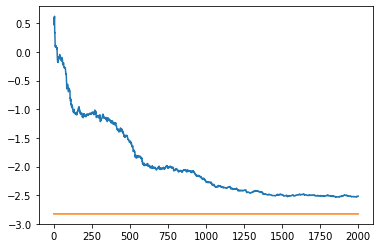

In [112]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [113]:
import pickle

file_to_store = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [114]:
import pickle

file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

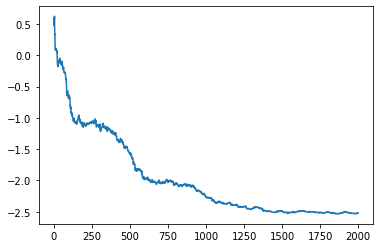

In [115]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

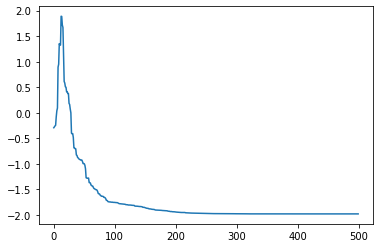

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'